
#**Deep Learning in Macroeconomics - MGS**

*The purpose of this project is to develop a predictive model to generate an expected yield curve of Malaysia Government Securities 10 years using deep learning method.* 
Source: 
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

In [175]:
# Import Python Tools
import numpy as np
import pandas as pd
import scipy as sp

# Graphic visualization tools
from matplotlib import pyplot as plt # same as from matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import express as px
from sklearn.preprocessing import MinMaxScaler
import time

#Statsmodel
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Machine Learning Tools
import tensorflow as tf
from tensorflow import keras

#For LSTM Model
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_excel
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

###**Import data from drive into google colab**



In [176]:
# Import files - Mount google drive as data repository
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
#read data
path ="/content/drive/MyDrive/Master Project/MP2 - Dataset (New).xlsx"
# Read the data
df = pd.read_excel(path)
df.shape
df.head(5)

,Date,MGS10 year (Yield %),FBM KLCI (MoM Chg %),Trade Balance (MoM Chg %),Foreign Holding (MoM Chg %),IP Index (YoY Chg %),CPI (YoY Chg %),UST10year (Yield %)
0,2017-01-31,4.124,1.815768,-45.707915,-1.626448,4.9,3.1,2.4531
1,2017-02-28,4.037,1.329911,83.182752,-4.043322,7.4,4.5,2.3899
2,2017-03-31,4.134,2.734728,-36.655084,-13.185784,5.6,4.9,2.3874
3,2017-04-30,4.052,1.607388,59.847815,3.872460,6.5,4.3,2.2802
4,2017-05-31,3.870,-0.123865,-30.886749,5.549900,7.2,3.8,2.2028


#**Testing Causation using Granger’s Causality Test**

######*The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.*

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

**The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.**


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

In [178]:
#before testing for Granger's Causality, drop irrelevant column i.e. Date
#Also, dropping UST10year and IP due to non-stationarity issue even after first differencing
df.drop(['Date'], axis=1, inplace=True)

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,MGS10 year (Yield %)_x,FBM KLCI (MoM Chg %)_x,Trade Balance (MoM Chg %)_x,Foreign Holding (MoM Chg %)_x,IP Index (YoY Chg %)_x,CPI (YoY Chg %)_x,UST10year (Yield %)_x
MGS10 year (Yield %)_y,1.0000,0.0000,0.4522,0.0079,0.0040,0.0000,0.0000
FBM KLCI (MoM Chg %)_y,0.0116,1.0000,0.0443,0.2127,0.0011,0.0098,0.0000
Trade Balance (MoM Chg %)_y,0.0289,0.0008,1.0000,0.0067,0.3286,0.0274,0.0673
Foreign Holding (MoM Chg %)_y,0.0101,0.1734,0.0001,1.0000,0.0857,0.1587,0.0002
IP Index (YoY Chg %)_y,0.0000,0.0001,0.9603,0.1259,1.0000,0.0001,0.0000
CPI (YoY Chg %)_y,0.0005,0.0000,0.5009,0.0133,0.0000,1.0000,0.0000
UST10year (Yield %)_y,0.0002,0.0000,0.0604,0.0008,0.5562,0.0466,1.0000


#Cointegration Test
Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

**Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.**

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.

In [179]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
MGS10 year (Yield %) ::  272.45    > 111.7797  =>   True
FBM KLCI (MoM Chg %) ::  140.88    > 83.9383   =>   True
Trade Balance (MoM Chg %) ::  85.02     > 60.0627   =>   True
Foreign Holding (MoM Chg %) ::  43.72     > 40.1749   =>   True
IP Index (YoY Chg %) ::  22.46     > 24.2761   =>   False
CPI (YoY Chg %) ::  7.58      > 12.3212   =>   False
UST10year (Yield %) ::  1.29      > 4.1296    =>   False


#**Split the Series into Training and Testing Data**

The VAR model will be fitted on df_train and then used to forecast. These forecasts will be compared against the actuals present in test data.

In [180]:
#nobs = 6
#df_train, df_test = df[0:-nobs], df[-nobs:]

df_train, df_test = df[:], df[:]

# Check size
print(df_train.shape)  # (42, 7)
print(df_test.shape)  # (18, 7)

(60, 7)
(60, 7)


#**Check for Stationarity and Make the Time Series Stationary**

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

Just to refresh, a stationary time series is one whose characteristics like mean and variance does not change over time.

In [181]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 10), 'pvalue':round(r[1], 10), 'n_lags':round(r[2], 10), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [182]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "MGS10 year (Yield %)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4424637825
 No. Lags Chosen       = 0
 Critical value 1%     = -3.546
 Critical value 5%     = -2.912
 Critical value 10%    = -2.594
 => P-Value = 0.561757779. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "FBM KLCI (MoM Chg %)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5578955692
 No. Lags Chosen       = 2
 Critical value 1%     = -3.551
 Critical value 5%     = -2.914
 Critical value 10%    = -2.595
 => P-Value = 8.5e-09. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Trade Balance (MoM Chg %)" 
    ---------------------------------

In [183]:
#The ADF test confirms few of the time series is nonstationary. Let’s difference all of them once and check again.

#Rename to df_differenced
df_differenced = df_train

In [184]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [185]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "MGS10 year (Yield %)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.2027676178
 No. Lags Chosen       = 0
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "FBM KLCI (MoM Chg %)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2216664469
 No. Lags Chosen       = 5
 Critical value 1%     = -3.56
 Critical value 5%     = -2.918
 Critical value 10%    = -2.597
 => P-Value = 5.21e-08. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Trade Balance (MoM Chg %)" 
    -----------------------------------------------
 Null Hypothesi

In [186]:
df_differenced.head()

,MGS10 year (Yield %),FBM KLCI (MoM Chg %),Trade Balance (MoM Chg %),Foreign Holding (MoM Chg %),IP Index (YoY Chg %),CPI (YoY Chg %),UST10year (Yield %)
1,-0.087,-0.485856,128.890667,-2.416874,2.5,1.4,-0.0632
2,0.097,1.404817,-119.837835,-9.142462,-1.8,0.4,-0.0025
3,-0.082,-1.127340,96.502898,17.058243,0.9,-0.6,-0.1072
4,-0.182,-1.731253,-90.734563,1.677440,0.7,-0.5,-0.0774
5,0.040,-0.000720,94.205666,-6.024843,-2.8,-0.4,0.1009


#**Selecting the Order (P) of VAR model**

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

In [187]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  12.894791049156497
BIC :  14.884184300718557
FPE :  403196.2610818595
HQIC:  13.66969990016711 

Lag Order = 2
AIC :  12.960509453810268
BIC :  16.724024947189704
FPE :  464759.07528025884
HQIC:  14.423139821462803 

Lag Order = 3
AIC :  12.678285384988168
BIC :  18.24800253450983
FPE :  438328.32083459926
HQIC:  14.837652944972842 

Lag Order = 4
AIC :  12.507864271609275
BIC :  19.916748573467306
FPE :  618521.9229535561
HQIC:  15.37293968016397 

Lag Order = 5
AIC :  11.35922502531903
BIC :  20.641150575952313
FPE :  592411.6808502023
HQIC:  14.938899711861382 

Lag Order = 6
AIC :  6.607805485758584
BIC :  17.797576541969693
FPE :  64968.42158360126
HQIC:  10.91085175667292 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [188]:
x = model.select_order(maxlags=6)
x.summary()

#Since the explicitly computed AIC is the lowest at lag 4, I choose the selected order as 4.

,AIC,BIC,FPE,HQIC
0,13.16,13.42*,5.196e+05,13.26
1,12.57,14.66,2.936e+05,13.37
2,12.57,16.47,3.208e+05,14.07
3,12.55,18.27,4.078e+05,14.75
4,12.29,19.84,5.577e+05,15.19
5,11.21,20.58,5.911e+05,14.81
6,6.608*,17.80,6.497e+04*,10.91*


#**Train the VAR Model of Selected Order(p)**

In [189]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Jun, 2022
Time:                     05:22:09
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    20.6412
Nobs:                     54.0000    HQIC:                   14.9389
Log likelihood:          -591.058    FPE:                    592412.
AIC:                      11.3592    Det(Omega_mle):         16583.7
--------------------------------------------------------------------
Results for equation MGS10 year (Yield %)
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                  0.006841         0.021791            0.314           0.754
L1.MGS10 year (Yield %)               -0.790270         0.235807           

#**Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [190]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

MGS10 year (Yield %) : 2.32
FBM KLCI (MoM Chg %) : 2.03
Trade Balance (MoM Chg %) : 1.76
Foreign Holding (MoM Chg %) : 1.95
IP Index (YoY Chg %) : 2.18
CPI (YoY Chg %) : 1.86
UST10year (Yield %) : 1.83


#How to Forecast VAR model using statsmodels

In order to forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [191]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 5

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

5


array([[ 1.20000000e-02,  9.62574204e+00,  9.36573976e+01,
         4.28755302e+00,  7.10000000e+00, -2.00000000e-01,
         8.65000000e-02],
       [ 1.87000000e-01, -1.11147121e+01, -3.33033071e+01,
        -2.96861553e+00,  3.40000000e+00,  2.00000000e-01,
         1.78500000e-01],
       [ 2.08000000e-01,  5.56416094e+00, -2.15121902e+01,
         2.50354128e+00,  4.00000000e+00,  7.00000000e-01,
         6.48000000e-02],
       [-7.20000000e-02, -4.68733152e+00, -2.86354338e+01,
        -3.98196231e+00,  3.30000000e+00,  4.00000000e-01,
        -1.07800000e-01],
       [ 5.40000000e-02,  6.63053100e+00,  9.15995937e+01,
         4.33804581e+00, -2.90000000e+00, -1.00000000e-01,
         6.58000000e-02]])

In [192]:
# Lets Forecast

nobs = 60
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

# The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced the original input data.

,MGS10 year (Yield %)_1d,FBM KLCI (MoM Chg %)_1d,Trade Balance (MoM Chg %)_1d,Foreign Holding (MoM Chg %)_1d,IP Index (YoY Chg %)_1d,CPI (YoY Chg %)_1d,UST10year (Yield %)_1d
0,-0.002461,-2.228152,178.793235,-1.688844,1.741115,-0.555183,-0.020190
1,-0.195733,0.267432,-51.102746,4.788797,-13.328551,-0.294073,0.112397
2,0.182229,-1.982178,51.759685,-5.550426,8.647777,-0.434959,-0.099378
3,-0.077239,-0.182660,-80.472541,1.844562,-15.106651,-0.534136,0.074996
4,0.150949,1.266394,-178.132502,-2.985100,14.271987,-0.273639,-0.176896
5,-0.054415,0.374770,181.367528,3.823129,-9.336845,-0.288808,0.198139
6,0.015068,1.617368,-182.683770,0.310340,9.483167,0.212782,-0.073611
7,-0.100050,-2.594321,320.095697,-0.598235,-1.450566,0.032419,0.100159
8,-0.001320,1.589794,-138.243692,0.387819,6.314596,0.462623,-0.082373
9,-0.019399,-4.124453,106.479014,-2.625991,-6.716529,-0.451550,-0.007760


#**Invert the transformation to get the real forecast**

In [193]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        if second_diff:
          df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [194]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['MGS10 year (Yield %)_forecast', 'FBM KLCI (MoM Chg %)_forecast', 'Trade Balance (MoM Chg %)_forecast', 'Foreign Holding (MoM Chg %)_forecast', 'CPI (YoY Chg %)_forecast']]

,MGS10 year (Yield %)_forecast,FBM KLCI (MoM Chg %)_forecast,Trade Balance (MoM Chg %)_forecast,Foreign Holding (MoM Chg %)_forecast,CPI (YoY Chg %)_forecast
0,3.560539,1.308883,242.411840,1.075354,2.644817
1,3.364806,1.576315,191.309094,5.864151,2.350744
2,3.547036,-0.405863,243.068779,0.313725,1.915785
3,3.469797,-0.588523,162.596238,2.158287,1.381649
4,3.620746,0.677871,-15.536264,-0.826813,1.108010
5,3.566331,1.052641,165.831263,2.996316,0.819202
6,3.581399,2.670009,-16.852506,3.306656,1.031984
7,3.481349,0.075688,303.243191,2.708421,1.064403
8,3.480029,1.665482,164.999498,3.096240,1.527025
9,3.460631,-2.458971,271.478513,0.470249,1.075475


#**Plot of Forecast vs Actuals**

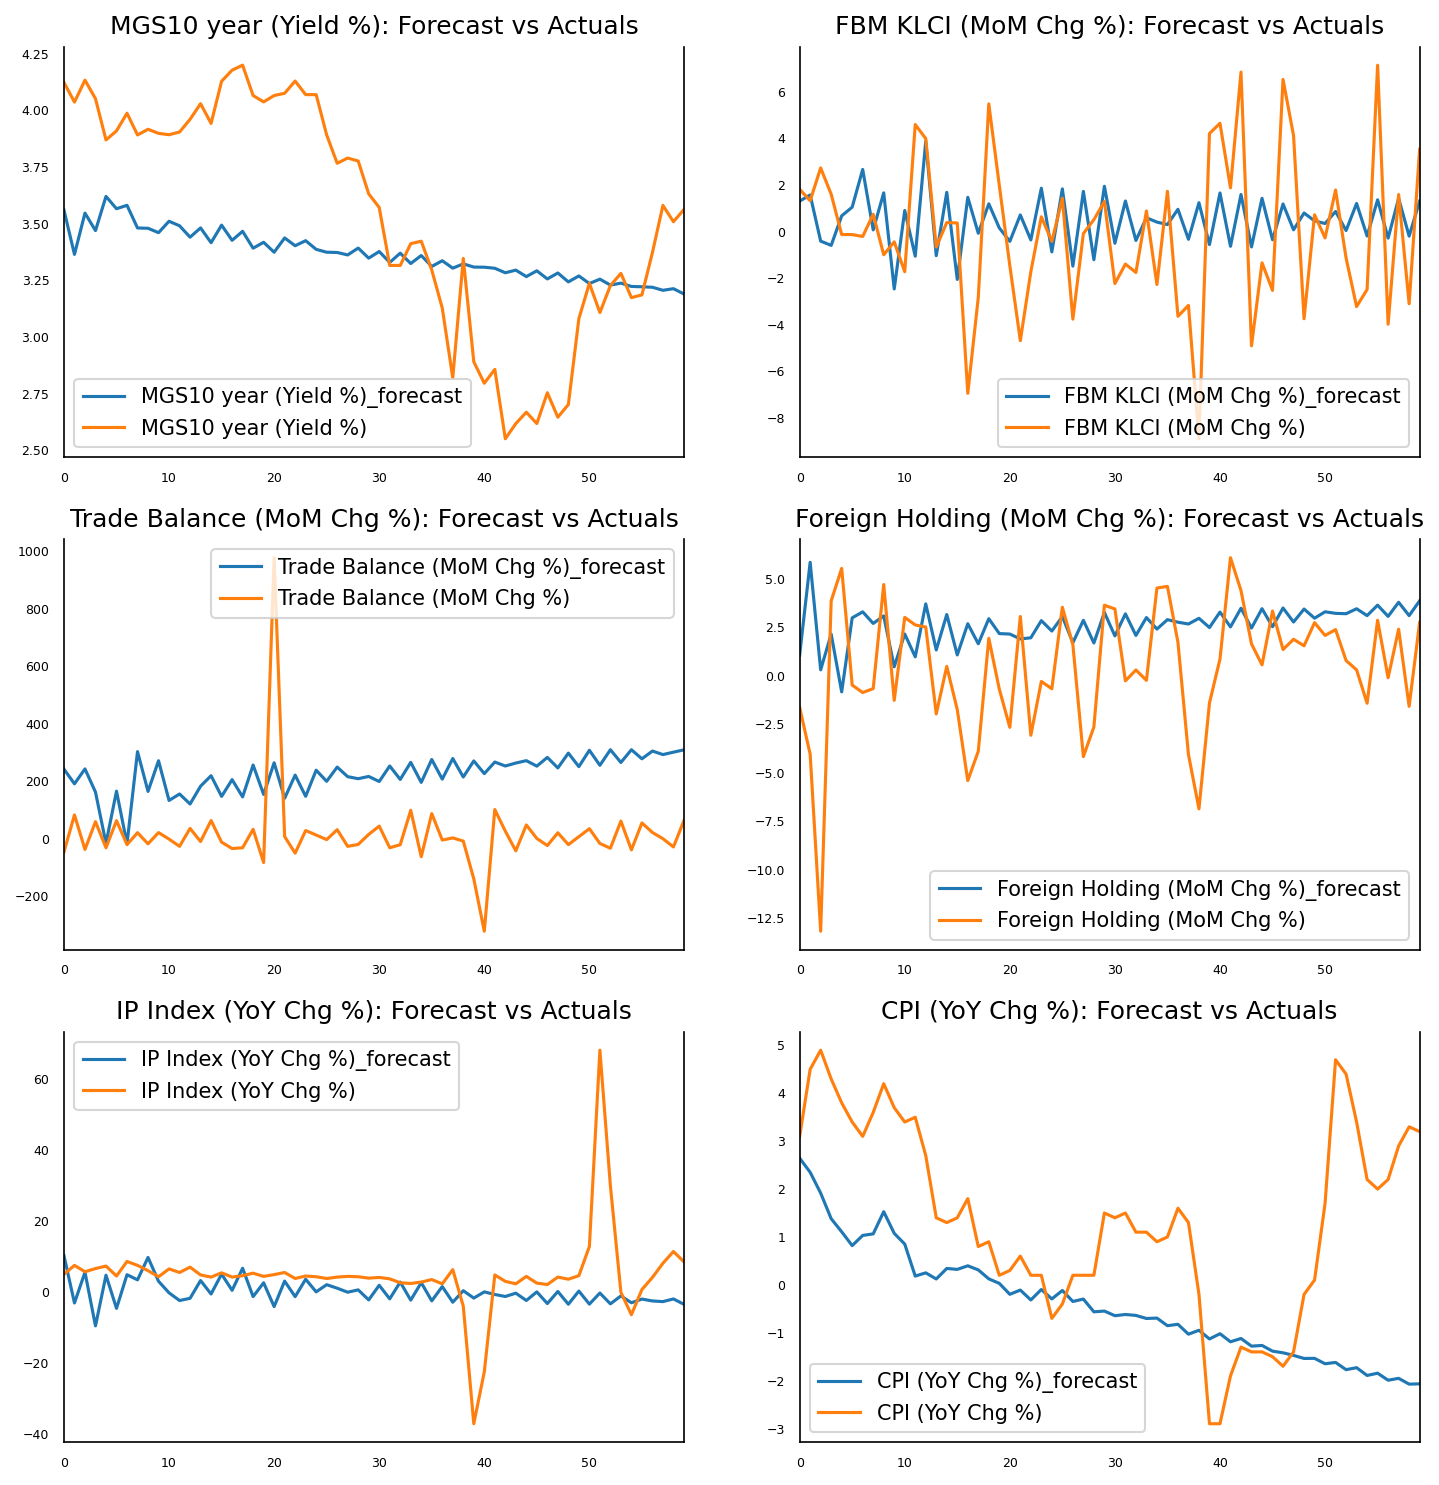

In [195]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#Evaluate the Forecasts

To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [196]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
 
    return({'Mean absolute error ': mae,'Test RMSE:':rmse})

  ##['MGS 10 year_forecast', 'FBM KLCI (MoM Chg %)_forecast', 'Trade Balance (Chg MoM %)_forecast', 'Foreign Holding (MoM Chg %)_forecast', 'IP Index (% YoY)_forecast', 'CPI Chg YoY (%)_forecast', 'UST10year - Lag 0_forecast']]

print('Forecast Accuracy of (VAR): MGS 10 year')
accuracy_prod = forecast_accuracy(df_results['MGS10 year (Yield %)_forecast'].values, df_test['MGS10 year (Yield %)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of (VAR): MGS 10 year
Mean absolute error  :  0.4073
Test RMSE: :  0.4685


In [197]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

  ##['MGS 10 year_forecast', 'FBM KLCI (MoM Chg %)_forecast', 'Trade Balance (Chg MoM %)_forecast', 'Foreign Holding (MoM Chg %)_forecast', 'IP Index (% YoY)_forecast', 'CPI Chg YoY (%)_forecast', 'UST10year - Lag 0_forecast']]

print('Forecast Accuracy of: MGS 10 year')
accuracy_prod = forecast_accuracy(df_results['MGS10 year (Yield %)_forecast'].values, df_test['MGS10 year (Yield %)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: FBM KLCI (MoM Chg %)')
accuracy_prod = forecast_accuracy(df_results['FBM KLCI (MoM Chg %)_forecast'].values, df_test['FBM KLCI (MoM Chg %)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Trade Balance (Chg MoM %)')
accuracy_prod = forecast_accuracy(df_results['Trade Balance (MoM Chg %)_forecast'].values, df_test['Trade Balance (MoM Chg %)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Foreign Holding (MoM Chg %)')
accuracy_prod = forecast_accuracy(df_results['Foreign Holding (MoM Chg %)_forecast'].values, df_test['Foreign Holding (MoM Chg %)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: CPI Chg YoY (%)')
accuracy_prod = forecast_accuracy(df_results['CPI (YoY Chg %)_forecast'].values, df_test['CPI (YoY Chg %)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))


Forecast Accuracy of: MGS 10 year
mape :  0.116
me :  -0.176
mae :  0.4073
mpe :  -0.0315
rmse :  0.4685
corr :  0.7176
minmax :  0.1089

Forecast Accuracy of: FBM KLCI (MoM Chg %)
mape :  2.0082
me :  0.509
mae :  2.5541
mpe :  -1.5921
rmse :  3.2451
corr :  0.1943
minmax :  -0.246

Forecast Accuracy of: Trade Balance (Chg MoM %)
mape :  24.2587
me :  209.0692
mae :  232.8161
mpe :  5.4935
rmse :  256.1195
corr :  0.1119
minmax :  0.9458

Forecast Accuracy of: Foreign Holding (MoM Chg %)
mape :  2.9194
me :  2.2282
mae :  3.0532
mpe :  -1.5797
rmse :  3.9953
corr :  0.1478
minmax :  1.8033

Forecast Accuracy of: CPI Chg YoY (%)
mape :  1.5284
me :  -1.7736
mae :  1.9697
mpe :  -1.1792
rmse :  2.5395
corr :  0.4134
minmax :  0.9805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':


In [198]:
#make final predictions
model = VAR(endog=df_train)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[  3.44381969   1.26855436 -29.24090663   2.63200632   4.68101802
    3.22770657   1.60462673]]


/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
